## CS349 Final HW Northwestern University
## Author: Tianyu Li
## Option 2 Stock Exchange Prediction

Using LSTM to predict Apple stock price

### Import packages

In [265]:
import csv
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,10)
import datetime as dt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator

import torch.autograd as autograd
from torch import Tensor                  
import torch.nn as nn                     
import torch.nn.functional as F           
import torch.optim as optim

from LSTM import LSTM

### Read and show Apple stock price from 2006 to 2018

3019


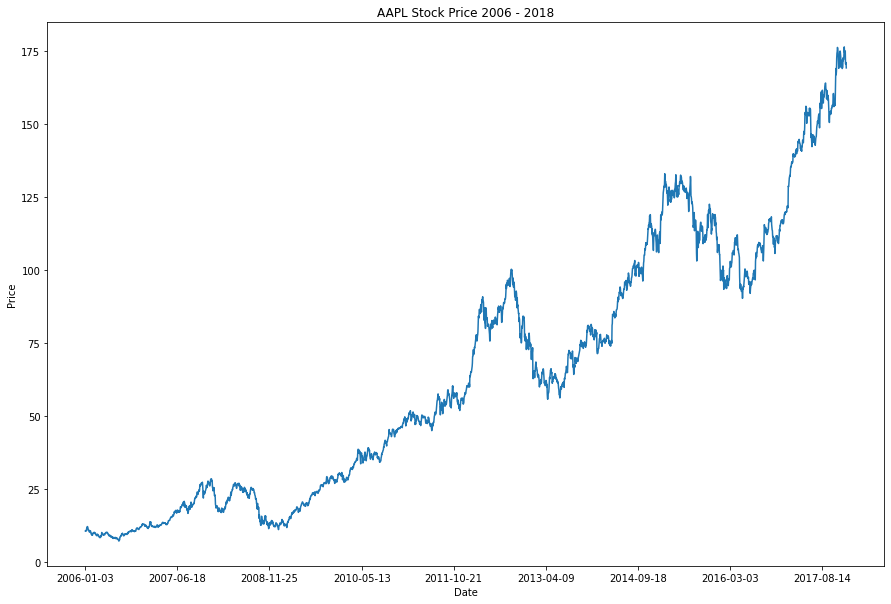

<Figure size 1080x648 with 0 Axes>

In [266]:

price_date = []
close_price = []

min_range = 0
max_range = 3090

with open('AAPL_data.csv', 'r') as file:
    reader = csv.reader(file, delimiter = ',')
    next(reader)
    count = 0
    for row in reader:
        if count >= min_range and count < max_range:
            price_date.append(row[0])
            close_price.append(float(row[4]))
        else:
            break
        count += 1
print(len(close_price))
price_date = np.array(price_date)
close_price = np.array(close_price)




plt.plot(price_date, close_price, marker='', linestyle='-')
frame1 = plt.gca()
frame1.axes.xaxis.set_major_locator(YearLocator())
plt.title('AAPL Stock Price 2006 - 2018')
plt.xlabel('Date')
plt.ylabel('Price')
plt.figure(figsize = (15,9))
plt.show()



#nomalizing the data
max_price = np.max(close_price)
close_price /= max_price

### Split data into training set and test set

In [267]:
def split_data(stock_data, window_len, test_fraction=0.2):
    
    sequence = []
    for s in range(len(stock_data) - window_len):
        single_seq = stock_data[s:s+window_len]
        sequence.append(single_seq)
        
    sequence = np.array(sequence)
    
    test_size = int(len(stock_data) * test_fraction)
    train_size = len(stock_data) - test_size
    
    train_sample = sequence[:train_size, :-1]  #the element before the last value in each sequence
    train_sample = np.expand_dims(train_sample, axis=2)
    
    train_label = sequence[:train_size, -1]    #the last element will be the label for that sequence
    train_label = np.expand_dims(train_label, axis=1)
    
    test_sample = sequence[train_size:,:-1]
    test_sample = np.expand_dims(test_sample, axis=2)
    
    test_label = sequence[train_size:, -1]
    test_label = np.expand_dims(test_label, axis=1)
    
    return train_sample, train_label, test_sample, test_label

window_len = 20
train_sample, train_label, test_sample, test_label = split_data(close_price, window_len, test_fraction=0.2)

print(train_sample.shape)
print(train_label.shape)
print(test_sample.shape)
print(test_label.shape)
    

(2416, 19, 1)
(2416, 1)
(583, 19, 1)
(583, 1)


### Define model for neural network training

In [268]:
input_dim = 1
hidden_dim = 32
n_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, n_layers=n_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_sample_tensor = torch.from_numpy(train_sample).type(torch.Tensor)
train_label_tensor = torch.from_numpy(train_label).type(torch.Tensor)
test_sample_tensor = torch.from_numpy(test_sample).type(torch.Tensor)
test_label_tensor = torch.from_numpy(test_label).type(torch.Tensor)

### Train the model

In [269]:
loss_arr = []
for i in range(num_epochs):
    predict_label = model(train_sample_tensor)
    loss = criterion(predict_label, train_label_tensor)
    loss_arr.append(loss.item())
    print("epoch: {}, loss: {}".format(i, loss))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

epoch: 0, loss: 0.05563843250274658
epoch: 1, loss: 0.03809785470366478
epoch: 2, loss: 0.04381007328629494
epoch: 3, loss: 0.03791792690753937
epoch: 4, loss: 0.03589995950460434
epoch: 5, loss: 0.03651076555252075
epoch: 6, loss: 0.03610464930534363
epoch: 7, loss: 0.03385164961218834
epoch: 8, loss: 0.030599862337112427
epoch: 9, loss: 0.027472814545035362
epoch: 10, loss: 0.024714794009923935
epoch: 11, loss: 0.01913183182477951
epoch: 12, loss: 0.0087629659101367
epoch: 13, loss: 0.0019182562828063965
epoch: 14, loss: 0.011262018233537674
epoch: 15, loss: 0.010927516035735607
epoch: 16, loss: 0.003680744208395481
epoch: 17, loss: 0.001208265544846654
epoch: 18, loss: 0.0017445993144065142
epoch: 19, loss: 0.003528355387970805
epoch: 20, loss: 0.00457976758480072
epoch: 21, loss: 0.004665468819439411
epoch: 22, loss: 0.004017671104520559
epoch: 23, loss: 0.0027904866728931665
epoch: 24, loss: 0.0013997547794133425
epoch: 25, loss: 0.0004887096583843231
epoch: 26, loss: 0.0003935766

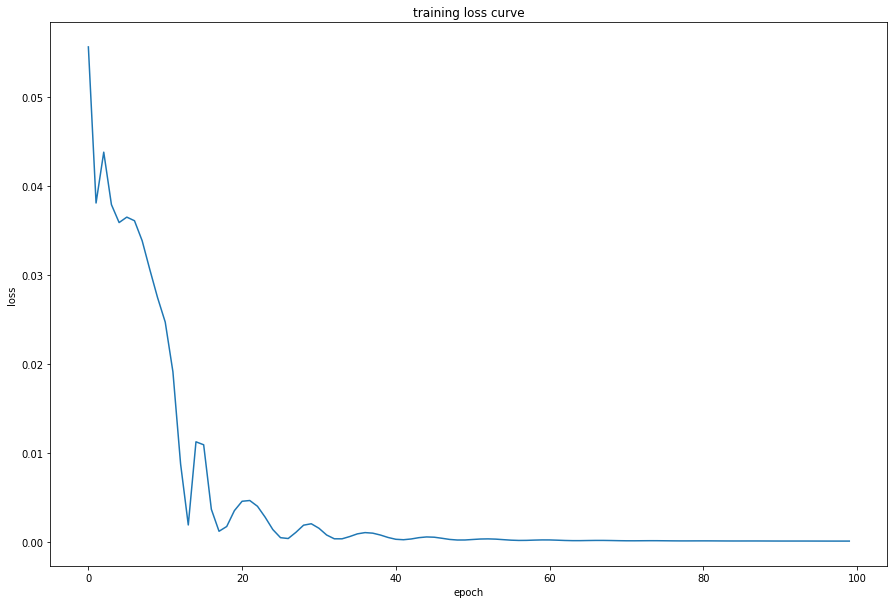

In [270]:
epoch_arr = np.linspace(0, num_epochs-1, num_epochs)
plt.plot(epoch_arr, loss_arr)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('training loss curve')
plt.show()


### Test the model with test set

In [ ]:
with torch.no_grad():
    test_predict_label = model(test_sample_tensor)

test_predict_label = np.squeeze(test_predict_label.detach().numpy())
test_label_arr = np.squeeze(test_label_tensor.detach().numpy())
# print(test_predict_label.shape)
# print(test_label_arr.shape)


# index_arr = np.linspace(0, len(test_predict_label)-1, len(test_predict_label))

# plt.plot(index_arr, test_predict_label, label='prediction')
# plt.plot(index_arr, test_label_arr, label='truth')
# plt.legend()
# plt.show()

### Show performance metrics

In [271]:

test_mse = np.average(np.square(test_predict_label*max_price - test_label_arr*max_price))
print("Test Accuracy Metrics Report")
print("Mean Squared Error: {}".format(test_mse))
print("Root Mean Squared Error: {}".format(np.sqrt(test_mse)))
print("Mean Absolute Error: {}".format(np.average(np.abs(test_predict_label*max_price - test_label_arr*max_price))))

Test Accuracy Metrics Report
Mean Squared Error: 41.586090087890625
Root Mean Squared Error: 6.448727607727051
Mean Absolute Error: 4.652420520782471


### Overlay the prediction part on all the price data

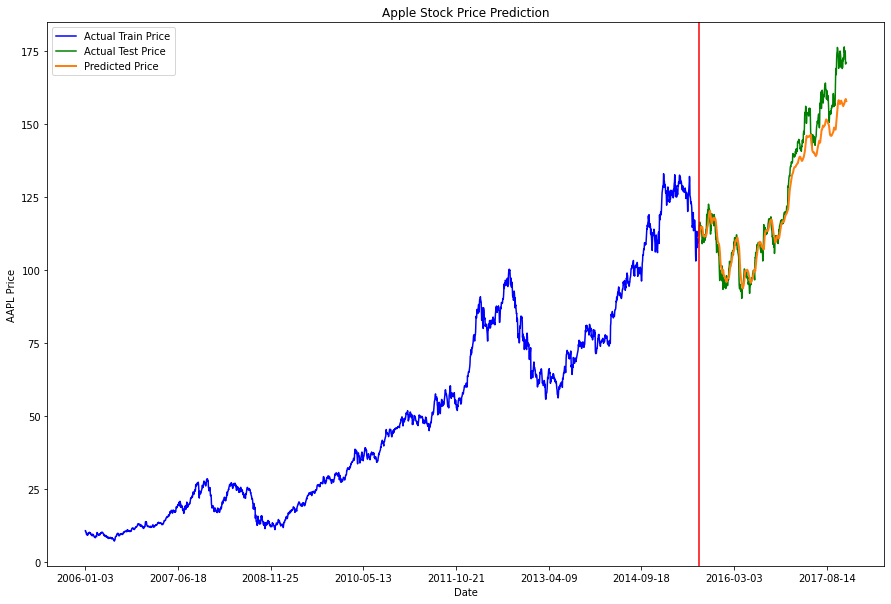

In [272]:


total_label = np.concatenate((np.squeeze(train_label), test_label_arr))
total_index_arr = np.linspace(0, len(total_label)-1, len(total_label))

predict_index_arr = np.linspace(train_label.shape[0]+1, train_label.shape[0]+test_label.shape[0], test_label.shape[0], dtype=np.int32)


total_label_price = total_label*max_price
plt.plot(price_date[:train_label.shape[0]+1], total_label_price[:train_label.shape[0]+1], label="Actual Train Price", color="b")
plt.plot(price_date[train_label.shape[0]+1:-window_len], total_label_price[train_label.shape[0]+1:], label="Actual Test Price", color="g")
plt.plot(price_date[predict_index_arr], test_predict_label*max_price, label="Predicted Price", color="tab:orange", linewidth=2)
plt.xlabel("Date")
plt.ylabel("AAPL Price")
plt.title("Apple Stock Price Prediction")
plt.legend()
plt.axvline(x=train_label.shape[0]+1, color='r')
frame1 = plt.gca()
frame1.axes.xaxis.set_major_locator(YearLocator())
plt.show()

### Use the trained model to predict 2018-2021 Apple stock price (beyond test data)

In [273]:
prediction_start_date = dt.datetime.strptime(price_date[-1],"%Y-%m-%d").date()

prediction_end_date = dt.date(2021, 1, 1)

print(prediction_start_date)
print(prediction_end_date)


days_diff = (prediction_end_date - prediction_start_date).days
print(days_diff)

starting_data = test_sample_tensor[-1]
starting_data = torch.unsqueeze(starting_data, 0)
# print(starting_data)


# print(torch.tensor([[[1.1]]]).shape)
# starting_data = torch.cat((starting_data[:,1:,:], torch.tensor([[[1.1]]])), 1)
# print(starting_data)

predict_further_arr = []
with torch.no_grad():
    for d in range(days_diff):
        predict_further_label = model(starting_data)     
        starting_data = torch.cat((starting_data[:,1:,:], torch.unsqueeze(predict_further_label, 0)),1)
        
        predict_further_arr.append(predict_further_label.item())
        
    
predict_further_arr = np.array(predict_further_arr)

print(predict_further_arr)


2017-12-29
2021-01-01
1099
[0.89475542 0.8851313  0.87466311 ... 0.66851723 0.66851723 0.66851723]


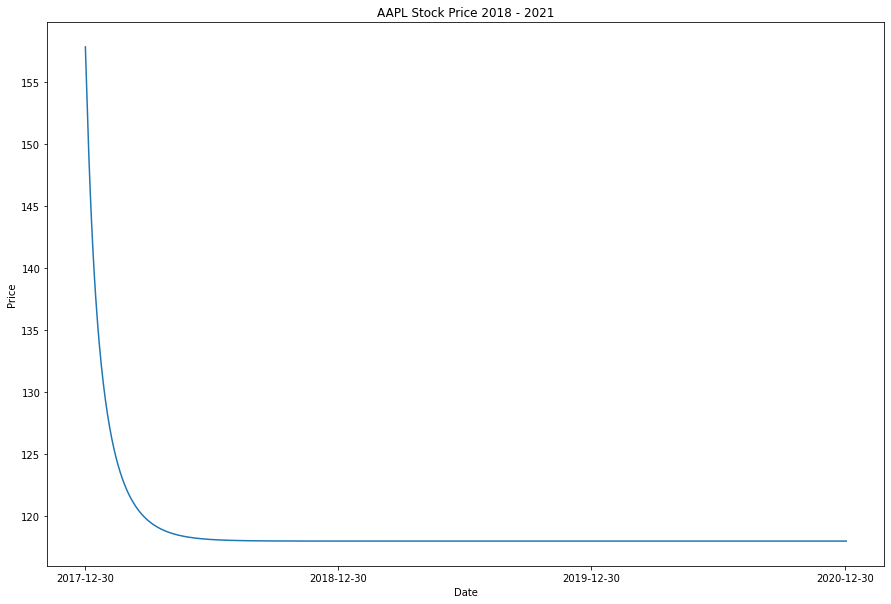

In [274]:
further_date_arr = []
curr_date = prediction_start_date
for fd in range(days_diff):
    curr_date = curr_date + dt.timedelta(days=1)
    curr_date_str = dt.datetime.strftime(curr_date, format='%Y-%m-%d')
    further_date_arr.append(curr_date_str)
    
    

plt.plot(further_date_arr, predict_further_arr*max_price, marker='', linestyle='-')
frame1 = plt.gca()
frame1.axes.xaxis.set_major_locator(YearLocator())
plt.title('AAPL Stock Price 2018 - 2021')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()